# CONTEXT

This dataset contains four tables about social media users.

* Users. csv contains data about the users of the social net.
* Friends.csv contains data about their friendship status
* Posts.csv contains data about the posts they made
* Reactions.csv contains data about the reactions to posts by their friends
* Task: Combine the tables in a way that lets you answer the following questions


Link to the dataset:

## Question to be answered

* What is the most common name on the social net? How many people belong to that name?
* List the five people with the most posts and reactions combined.
* Create a plot of the friendship graph for all users named „Jean-Luc Picard“ (up to degree 2)

In [5]:
import pandas as pd
import psycopg2
import os
from os import path, listdir
from os.path import join

In [2]:
# show the list of all the data in the folder
path = "../Data Engineer/data"
listdir(path)

['friends_table.csv',
 'posts_table.csv',
 'reactions_table.csv',
 'user_table.csv']

## Create a function that can be used to load the data into dataframe easily

In [3]:
def open_data(name,directory=path):
    data = os.path.join(directory,name)
    return pd.read_csv(data)

### Load the Friend ID Data

In [4]:
friends_df = open_data('friends_table.csv')
friends_df.head()

,Friend 1,Friend 2
0,1,555
1,1,921
2,1,213
3,1,184
4,1,242


In [8]:
# print the max id for friend 1 and two
friends_df["Friend 1"].max(), friends_df["Friend 2"].max()

(1000, 1000)

### Load the the Post Data

In [6]:
posts_df = open_data('posts_table.csv')
posts_df.head()

,User,Post Type,Post Date
0,1,Image,1588166977
1,1,Status_Change,1588167686
2,1,Text,1588168633
3,1,Image,1588163570
4,1,Image,1588168986


In [7]:
posts_df.User.describe()

count    13158.000000
mean       504.566347
std        289.159974
min          1.000000
25%        257.000000
50%        500.000000
75%        757.000000
max       1000.000000
Name: User, dtype: float64

### Load the reaction reaction table

In [74]:
reactions_df = open_data('reactions_table.csv')
reactions_df.head()

,User,Reaction Type,Reaction Date
0,3741,Comment,1588168107
1,711,Emoticon,1588166846
2,701,Emoticon,1588163334
3,4750,Emoticon,1588168182
4,656,Comment,1588162272


### Load User information Data 

In [81]:
users_df = open_data('user_table.csv')
users_df.head()

,Surname,Name,Age,Subscription Date
0,Smith,Sarah,30,1588157373
1,Picard,Francine,32,1588161732
2,Roth,Hans,40,1588157337
3,Pomme,Ali,28,1588165636
4,Di Lillo,Jordi,42,1588156042


### Transform the User Data

In [82]:
users_df["User"]= list(range(1,(len(users_df)+1)))
users_df

,Surname,Name,Age,Subscription Date,User
0,Smith,Sarah,30,1588157373,1
1,Picard,Francine,32,1588161732,2
2,Roth,Hans,40,1588157337,3
3,Pomme,Ali,28,1588165636,4
4,Di Lillo,Jordi,42,1588156042,5
...,...,...,...,...,...
995,Kirk,Lee,19,1588160246,996
996,Pomme,Franz,40,1588159625,997
997,Gwahsi,Thomas,40,1588165504,998
998,Beierlorzer,Jean-Luc,32,1588151074,999


### Merge Name

In [83]:
def get_name(file):
    file["name"] = file["Surname"]+ " " + file["Name"]
    file.drop(["Surname","Name"], axis = 1)
    return file[["User", "Age", "name", "Subscription Date"]]

users_df = get_name(users_df)
users_df

,User,Age,name,Subscription Date
0,1,30,Smith Sarah,1588157373
1,2,32,Picard Francine,1588161732
2,3,40,Roth Hans,1588157337
3,4,28,Pomme Ali,1588165636
4,5,42,Di Lillo Jordi,1588156042
...,...,...,...,...
995,996,19,Kirk Lee,1588160246
996,997,40,Pomme Franz,1588159625
997,998,40,Gwahsi Thomas,1588165504
998,999,32,Beierlorzer Jean-Luc,1588151074


### Transform Columns

In [85]:
def columns_trans(data):
    name =  [file.lower().replace(" ","_") for file in data.columns.astype(str)]
    data.columns = name
    return data
    

users_df = columns_trans(users_df)
users_df

,user,age,name,subscription_date
0,1,30,Smith Sarah,1588157373
1,2,32,Picard Francine,1588161732
2,3,40,Roth Hans,1588157337
3,4,28,Pomme Ali,1588165636
4,5,42,Di Lillo Jordi,1588156042
...,...,...,...,...
995,996,19,Kirk Lee,1588160246
996,997,40,Pomme Franz,1588159625
997,998,40,Gwahsi Thomas,1588165504
998,999,32,Beierlorzer Jean-Luc,1588151074


## Database Connection

Create a connection to the database

List of data we are using

* users_df 
* reactions_df
* posts_df
* friends_df

In [133]:
def create_database():
    # connect to default database
    conn = psycopg2.connect("host=localhost dbname=postgres user=postgres password = 1118")
    conn.set_session(autocommit = True)
    cur = conn.cursor()
    
    
    
    # create sparkify database with UTF8 enconding
    cur.execute("DROP DATABASE IF EXISTS socialmedia")
    cur.execute("CREATE DATABASE socialmedia")
    
    
    #close connection to efault database
    conn.close()
    
    
    # connect to sparkify database
    conn = psycopg2.connect("host=localhost dbname=socialmedia user=postgres password=1118")
    conn.set_session(autocommit = True) # set commit to automatic
    cur = conn.cursor()
    
    return cur,conn

In [134]:
def drop_tables(cur,conn):
    for query in drop_table_queries:
        cur.execute(query)
        conn.commit()   

### Call the create_database function to create your database

In [ ]:
cur,conn = create_database()

### Create database table for USER

In [136]:
users_df.columns

Index(['user', 'age', 'name', 'subscription_date'], dtype='object')

In [137]:
user_table_create = ("""CREATE TABLE IF NOT EXISTS user_info(
user_id VARCHAR PRIMARY KEY,
age INT,
name VARCHAR,
subscription_date INT);""")

cur.execute(user_table_create)

### Insert Data into the user table

In [145]:
user_table_insert = ("""INSERT INTO user_info (
user_id,
age,
name,
subscription_date)
VALUES(%s, %s, %s, %s);""")

In [147]:
for i, row in users_df.iterrows():
    cur.execute(user_table_insert, list(row))

### Create database table for Reactions

In [139]:
reactions_df.columns

Index(['User', 'Reaction Type', 'Reaction Date'], dtype='object')

In [140]:
reactions_table_create = ("""CREATE TABLE IF NOT EXISTS reactions(
user_id VARCHAR,
reactions VARCHAR,
reaction_date INT);""")

cur.execute(reactions_table_create)

### Insert Data into reactions table

In [153]:
reactions_table_insert = ("""INSERT INTO  reactions (
user_id,
reactions,
reaction_date)
VALUES(%s, %s, %s);""")

for i, row in reactions_df.iterrows():
    cur.execute(reactions_table_insert, list(row))

### Create database table for Friends

In [141]:
friends_df.columns

Index(['Friend 1', 'Friend 2'], dtype='object')

In [142]:
friends_table_create = ("""CREATE TABLE IF NOT EXISTS friends(
friend1 VARCHAR,
friend2 VARCHAR
);""")

cur.execute(friends_table_create)

### Insert Data into friends table

In [156]:
friends_table_insert = ("""INSERT INTO  friends (
friend1,
friend2)
VALUES(%s, %s);""")

for i, row in friends_df.iterrows():
    cur.execute(friends_table_insert, list(row))

### Create database for Posts

In [143]:
posts_df.columns

Index(['User', 'Post Type', 'Post Date'], dtype='object')

In [144]:
posts_table_create = ("""CREATE TABLE IF NOT EXISTS posts(
User_id VARCHAR,
post_type VARCHAR,
post_date VARCHAR
);""")

cur.execute(posts_table_create)

### Insert Data into Posts table

In [157]:
posts_table_insert = ("""INSERT INTO  posts (
user_id,
post_type,
post_date)
VALUES(%s, %s, %s);""")

for i, row in posts_df.iterrows():
    cur.execute(posts_table_insert, list(row))

## Connect to the already created Database

In [6]:
conn = psycopg2.connect("host=localhost dbname=socialmedia user=postgres password=1118")
conn.set_session(autocommit = True) # set commit to automatic
cur = conn.cursor()

## Writing Query to answer Questions

* What is the most common name on the social net? How many people belong to that name?

In [7]:
query1 = """SELECT (name), COUNT(*) AS name_count
FROM user_info
GROUP BY name
ORDER BY name_count desc
LIMIT 10;"""

In [19]:
cur.execute(query1)

for row in cur.fetchall():
    print(row)

('Bond Josie', 11)
('Smith Thomas', 10)
('Picard Timothy', 10)
('Meier Thomas', 10)
('Bond Sarah', 10)
('Kirk Jordi', 8)
('Mueller Ali', 8)
('Mueller Franz', 8)
('Mueller Simon', 8)
('Smith Sarah', 8)


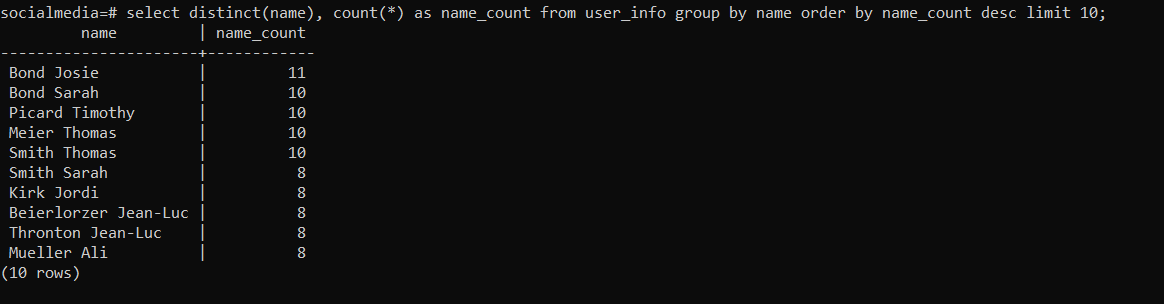

In [20]:
from IPython.display import Image
Image(filename='picture_1.png') 

* List the five people with the most posts and reactions combined.

In [26]:
query2 = """SELECT user_info.user_id AS id, name, COUNT(pr) AS posts_and_reactions
from user_info, 
(SELECT  posts.user_id 
FROM posts
INNER JOIN reactions
ON reactions.user_id = posts.user_id) as pr
WHERE user_info.user_id = pr.user_id
GROUP BY id, name
ORDER BY posts_and_reactions desc 
LIMIT 5;"""

In [28]:
cur.execute(query2)
for row in cur.fetchall():
    print(row)

('642', 'Mueller Ali', 5208)
('664', 'Picard Zoe', 3120)
('67', 'Gwahsi Agaba', 2730)
('690', 'Di Lillo Robert', 2728)
('465', 'Bond Hans', 2712)


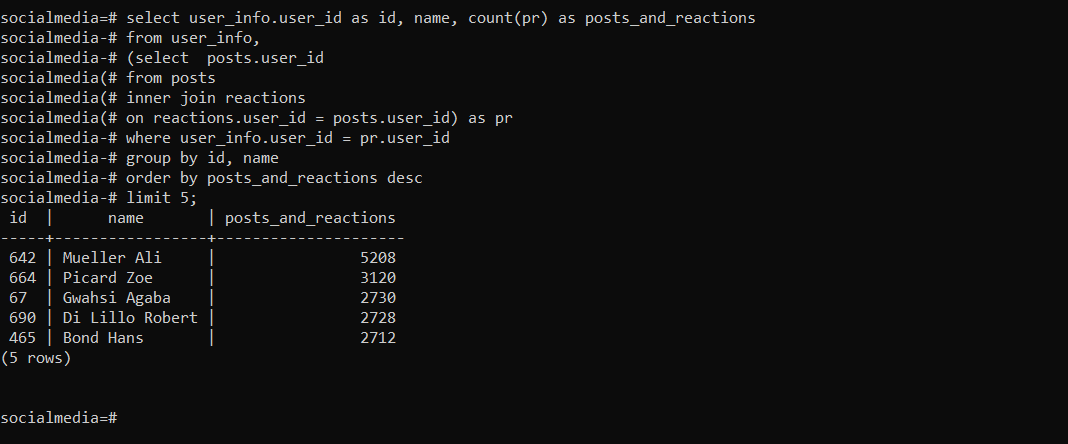

In [21]:
Image(filename = "picture_2.png")